Occupation CAMSIS Table (Top 10):
             occupation  count   mean_income  mean_edu_idx  camsis_score
0               Artists    373  63054.412869      0.721180      1.350649
1           Journalists    485  66116.032990      0.785567      1.344116
2           Freelancers    353  59061.577904      0.645892      1.287822
3                Police    545  70733.990826      0.908257      1.264387
4            IT Support    598  73168.080268      0.973244      1.109405
5          Retail Sales    686  76427.148688      0.992711      0.957674
6      Domestic Workers    735  79548.360544      1.013605      0.768718
7       Factory Workers    846  81804.838061      1.140662      0.556382
8               Drivers    856  85946.005841      1.089953      0.333534
9  Construction Workers   1009  89399.744301      1.116947      0.115709

Correlation Summary:
Pearson Income: PearsonRResult(statistic=np.float64(-0.9849099615941272), pvalue=np.float64(3.648301413842944e-15))
Spearman Income: Signific

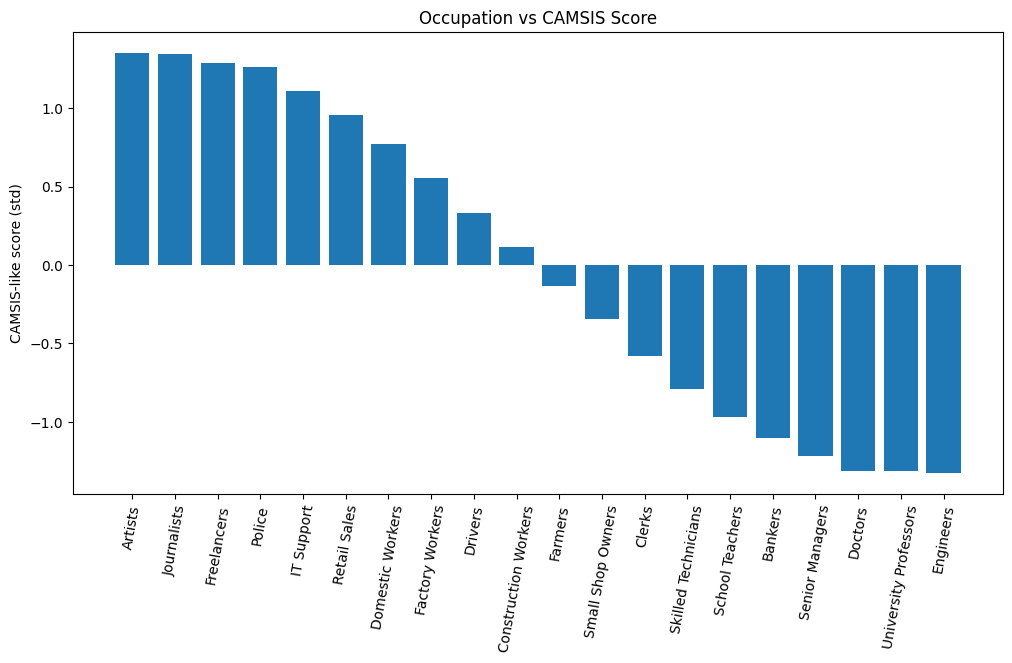

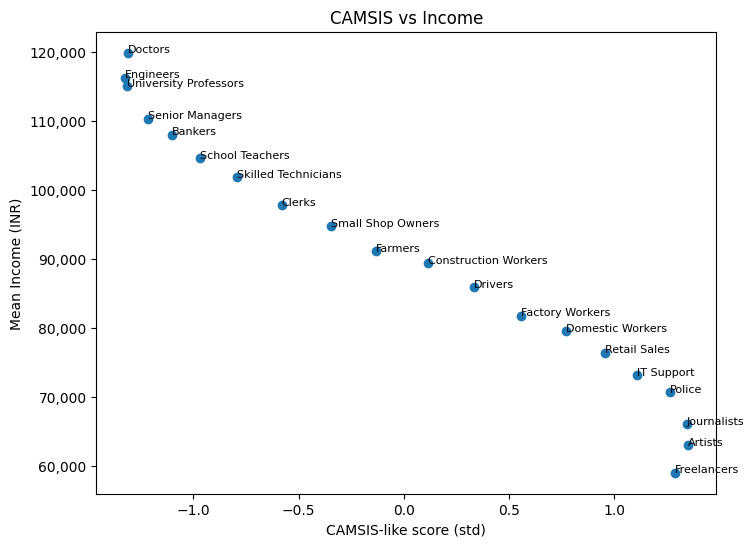

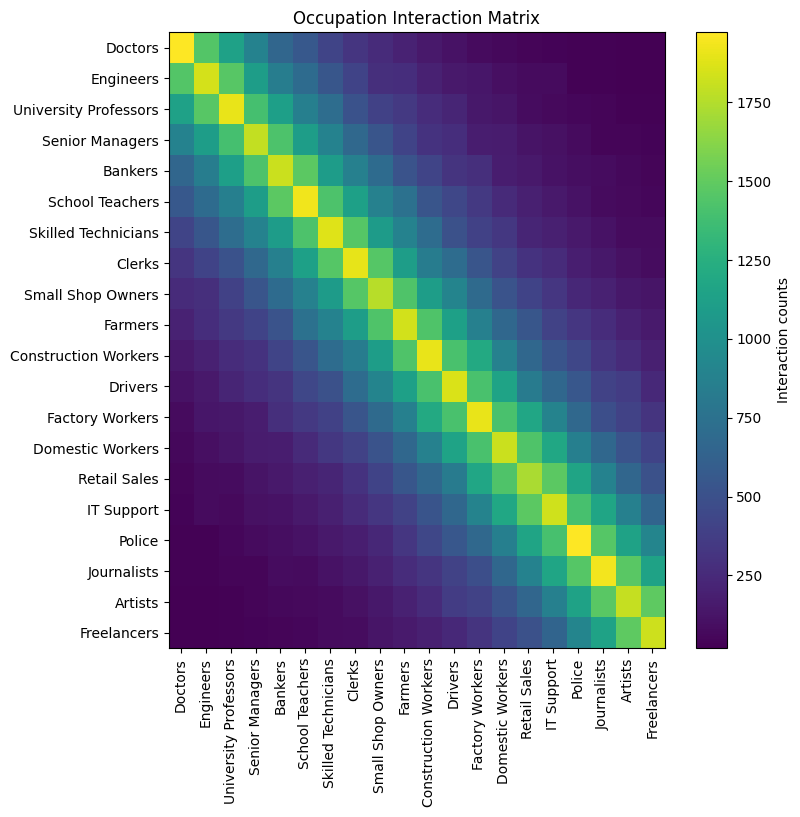

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from matplotlib import ticker

# -----------------------------
# 1) Synthetic Occupation Dataset
# -----------------------------
occupations = [
    "Doctors", "Engineers", "University Professors", "Senior Managers", "Bankers",
    "School Teachers", "Skilled Technicians", "Clerks", "Small Shop Owners", "Farmers",
    "Construction Workers", "Drivers", "Factory Workers", "Domestic Workers", "Retail Sales",
    "IT Support", "Police", "Journalists", "Artists", "Freelancers"
]
n_occ = len(occupations)
n_people = 20000

rng = np.random.default_rng(42)

# Occupation assignment
occ_probs = np.linspace(1, 0.2, n_occ)
occ_probs = occ_probs / occ_probs.sum()
people_occ = rng.choice(occupations, size=n_people, p=occ_probs)

# Income distribution
base_income = np.linspace(120000, 60000, n_occ)
person_income = np.array([base_income[occupations.index(o)] for o in people_occ]) * (1 + rng.normal(0, 0.25, n_people))
person_income = np.maximum(5000, person_income).astype(int)

# Education
education_levels = ["No formal", "Primary", "Secondary", "Graduate", "Postgraduate"]
education_map = {k: i for i, k in enumerate(education_levels)}

person_edu_idx = []
for o in people_occ:
    idx = occupations.index(o)
    probs = np.exp(-np.arange(len(education_levels)) / (1 + (n_occ-idx)/8.0))
    probs = probs / probs.sum()
    person_edu_idx.append(rng.choice(len(education_levels), p=probs))
person_edu_idx = np.array(person_edu_idx)
person_edu = [education_levels[i] for i in person_edu_idx]

# Build DataFrame
df = pd.DataFrame({
    "occupation": people_occ,
    "income": person_income,
    "education": person_edu,
    "education_idx": person_edu_idx,
})

# -----------------------------
# 2) Interaction Matrix
# -----------------------------
M = 120000
occ_idx = np.array([occupations.index(o) for o in people_occ])

occ_similarity = np.zeros((n_occ, n_occ))
for i in range(n_occ):
    for j in range(n_occ):
        dist = abs(i - j)
        occ_similarity[i, j] = np.exp(-dist/4.0)

occ_similarity = occ_similarity / occ_similarity.sum()
flat_pairs = rng.choice(n_occ*n_occ, size=M, p=occ_similarity.flatten())
pairs_i, pairs_j = np.unravel_index(flat_pairs, (n_occ, n_occ))

occ_matrix = np.zeros((n_occ, n_occ), dtype=int)
for ia, ib in zip(pairs_i, pairs_j):
    occ_matrix[ia, ib] += 1
occ_matrix = occ_matrix + occ_matrix.T

# -----------------------------
# 3) CAMSIS Scale Construction
# -----------------------------
N = occ_matrix.sum()
P = occ_matrix / N
r = P.sum(axis=1)
c = P.sum(axis=0)
expected = np.outer(r, c)
S = (P - expected) / np.sqrt(expected)

svd = TruncatedSVD(n_components=1, random_state=42)
u = svd.fit_transform(S)[:, 0]
camsis_scores = (u - u.mean()) / u.std()

occ_df = df.groupby("occupation").agg(
    count=("occupation", "size"),
    mean_income=("income", "mean"),
    mean_edu_idx=("education_idx", "mean"),
).reindex(occupations).reset_index()
occ_df["camsis_score"] = camsis_scores
occ_df = occ_df.sort_values("camsis_score", ascending=False).reset_index(drop=True)

print("Occupation CAMSIS Table (Top 10):")
print(occ_df.head(10))

# -----------------------------
# 4) Validation
# -----------------------------
pearson_income = pearsonr(occ_df["camsis_score"], occ_df["mean_income"])
spearman_income = spearmanr(occ_df["camsis_score"], occ_df["mean_income"])
pearson_edu = pearsonr(occ_df["camsis_score"], occ_df["mean_edu_idx"])
spearman_edu = spearmanr(occ_df["camsis_score"], occ_df["mean_edu_idx"])

print("\nCorrelation Summary:")
print("Pearson Income:", pearson_income)
print("Spearman Income:", spearman_income)
print("Pearson Education:", pearson_edu)
print("Spearman Education:", spearman_edu)

# -----------------------------
# 5) Plots
# -----------------------------
plt.figure(figsize=(12,6))
plt.bar(occ_df["occupation"], occ_df["camsis_score"])
plt.xticks(rotation=80)
plt.ylabel("CAMSIS-like score (std)")
plt.title("Occupation vs CAMSIS Score")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(occ_df["camsis_score"], occ_df["mean_income"])
for i, txt in enumerate(occ_df["occupation"]):
    plt.annotate(txt, (occ_df["camsis_score"].iloc[i], occ_df["mean_income"].iloc[i]), fontsize=8)
plt.xlabel("CAMSIS-like score (std)")
plt.ylabel("Mean Income (INR)")
plt.title("CAMSIS vs Income")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(occ_matrix, aspect='auto')
plt.colorbar(label="Interaction counts")
plt.xticks(ticks=np.arange(n_occ), labels=occupations, rotation=90)
plt.yticks(ticks=np.arange(n_occ), labels=occupations)
plt.title("Occupation Interaction Matrix")
plt.show()
